# Simulation-based Calibration in SBI

After a posterior has been trained given a simulation, predictions from this posterior should be made subject to several diagnostical tests. [Posterior Predictive Checks](12_diagnosis_posterior_predictive_check.ipynb) are one such diagnostic. Another important approach to such diagnostics is simulation-based calibration as conceived by [Talts et al, 2018](https://arxiv.org/abs/1804.06788).

**Simulation-based calibration** (SBC) boils down to visual (qualitative) way as well as to a quantitive measure to check, if the uncertainties obtained from the ensemble of posterior samples meets expectations. In this way, SBC can unveil if the uncertainties of the posterior samples can be considered well calibrated or healthy. SBC can hence be used to uncover malignant posteriors. SBC cannot be used to fix this posterior. As such, SBC without inconsistent artifacts can be viewed as a necessary condition for a valid inference using a posterior.

## in a nutshell

SBC repeats posterior inference to obtain predicted samples of $x_{true}$ (in turn obtained from $simulator(\theta_{true})$). SBC then ranks these $\theta_{post}$ with respect to $\theta_{true}$. This rank is calculated by counting those samples $\theta_{post}$ which fall below $\theta_{true}$. With this rank statistic, SBC is sensitive to the relative position of all predictions with respect to the ground truth (__bias__). In addition, SBC can report how far apart predictions are distributed from the ground truth (__dispersion__). 

The core idea behind SBC is two fold: 

- the SBC ranks of posterior samples with respect to their ground truth follow a uniform distribution.  
(If the SBC ranks are not uniformly distributed, the posterior is not well calibrated.)

- samples from the data averaged posterior are distributed according to the prior

### What can SBC diagnose?

**SBC can inform us whether we are not wrong.** However, it cannot tell us whether we are right. SBC checks a necessary condition. For example, imagine you run SBC using the prior as a posterior. The ranks would be perfectly uniform. But the inference would be wrong.

**The [Posterior Predictive Checks](12_diagnosis_posterior_predictive_check.ipynb) can be seen as the complementary sufficient check for** the posterior (only as a methaphor, no theoretical guarantees here): using the prior as a posterior and then doing predictive checks would clearly show that inference failed. 

Summary:

- SBC can tell us whether a method produces posteriors that are have a systematic negative or positive bias (shift in the mean)
- SBC can tell us whether a method produces posteriors that are systematically over- or underdispersed (too large or too small variance) 

## a healthy posterior

Let's take the gaussian linear simulation and run inference with (S)NPE on it.

In [1]:
import torch
from torch import eye, ones, zeros
from torch.distributions import MultivariateNormal

from sbi.analysis import check_sbc, run_sbc, get_nltp
from sbi.inference import SNPE_C, simulate_for_sbi
from sbi.simulators import linear_gaussian

In [8]:
num_dim = 3
num_simulations = 1_000
x_o = zeros(1, num_dim)

likelihood_shift = -1.0 * ones(num_dim)
likelihood_cov = 0.3 * eye(num_dim)

likelihood_shift_nil = zeros(num_dim)
likelihood_cov_nil = eye(num_dim)


prior_mean = zeros(num_dim)
prior_cov = eye(num_dim)
prior = MultivariateNormal(loc=prior_mean, covariance_matrix=prior_cov)


In [9]:
def simulator(theta):
    return linear_gaussian(theta, likelihood_shift_nil, likelihood_cov_nil)

theta, x = simulate_for_sbi(simulator, prior, num_simulations)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [10]:
inferer = SNPE_C(prior, show_progress_bars=False, density_estimator="mdn")
_ = inferer.append_simulations(theta, x).train(
        training_batch_size=100, max_num_epochs=1
    )

In [11]:
posterior = inferer.build_posterior().set_default_x(x_o)
posterior_samples = posterior.sample((5000,))

Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

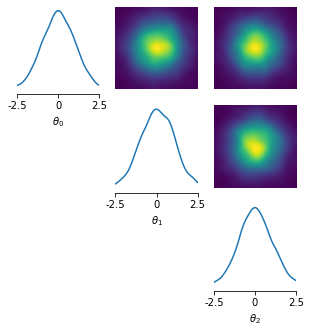

In [12]:
from sbi.analysis import pairplot

fig, ax = pairplot(
    samples=posterior_samples,
    limits=torch.tensor([[-2.5, 2.5]]*3),
    upper=['kde'],
    diag=['kde'],
    figsize=(5,5),
    labels=[rf"$\theta_{d}$" for d in range(3)]
)

We have a working and trained posterior at this point. Let's look at the SBC metrics in a case, where all predictions should be healthy.

In [24]:
num_sbc_runs = 150
thetas = prior.sample((num_sbc_runs,))
xs = simulator(thetas)

In [25]:
ranks, dap_samples = run_sbc(thetas, xs, posterior, num_workers=4)

/home/steinb95/development/sbi/sbi/analysis/sbc.py:50: UserWarning: Number of SBC samples should be on the order of 100s to give realiable
            results. We recommend using 300.
  warnings.warn(


Running 150 sbc runs in 150
                    batches.:   0%|          | 0/150 [00:00<?, ?it/s]

In [26]:
check_stats = check_sbc(ranks, thetas, dap_samples, 300)

In [27]:
print(check_stats)

{'ks_pvals': tensor([0., 0., 0.]), 'c2st_ranks': tensor([0.7367, 0.7567, 0.6933]), 'c2st_dap': tensor([0.4733, 0.5100, 0.4933])}
